In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
from stable_baselines3 import TD3
from collections import OrderedDict

from src.model.flow_matching import ConditionalFlowMatching
from src.model.base_models.unet_mlp import TDFlowUnet
from src.training import TDFlowTrainer


# os.environ['MUJOCO_GL'] = 'glfw'

In [2]:
class PointMassMazeDataset(Dataset):

    def __init__(self, file_path='data/point_mass_maze/rnd/buffer/', task='reach_top_left'):
        self.task = task
        model_path = f'td3_point_mass_expert_{task}'
        model =  TD3.load(model_path)
        self.policy = self.configure_policy(model)
        self.file_path = file_path
        self.s = []
        self.a = []
        self.s_next = []
        self.a_next = []
        for i in tqdm(range(0, 10_000)):
            idx = f"{i}"
            while len(idx)<6:
                idx = '0'+idx
            data = np.load(file_path+f'episode_{idx}_1000.npz')
            self.s.append(data['observation'][:-1])
            self.s_next.append(data['observation'][1:])
            self.a.append(data['action'][1:])
            self.a_next.append(self.policy(data['observation'][1:]))

        self.s = torch.from_numpy(np.concat(self.s)).to(torch.float32)
        self.s_next = torch.from_numpy(np.concat(self.s_next)).to(torch.float32)
        self.a = torch.from_numpy(np.concat(self.a)).to(torch.float32)
        self.a_next = torch.from_numpy(np.concat(self.a_next)).to(torch.float32)

    def configure_policy(self, model):
        def policy(s):
            obs = OrderedDict()
            obs['position'] = s[:, :2]
            obs['velocity'] = s[:, 2:]
            obs_next, _ = model.predict(obs, deterministic=True)
            return obs_next
        return policy
    
    def __len__(self):
        return self.a.shape[0]
    
    def __getitem__(self, idx):
        return self.s[idx], self.a[idx], self.s_next[idx], self.a_next[idx]

In [3]:
dataset = PointMassMazeDataset(task='reach_top_left')

100%|██████████| 10000/10000 [00:17<00:00, 580.44it/s]


In [4]:
train_loader = DataLoader(dataset, batch_size=1024, shuffle=True)

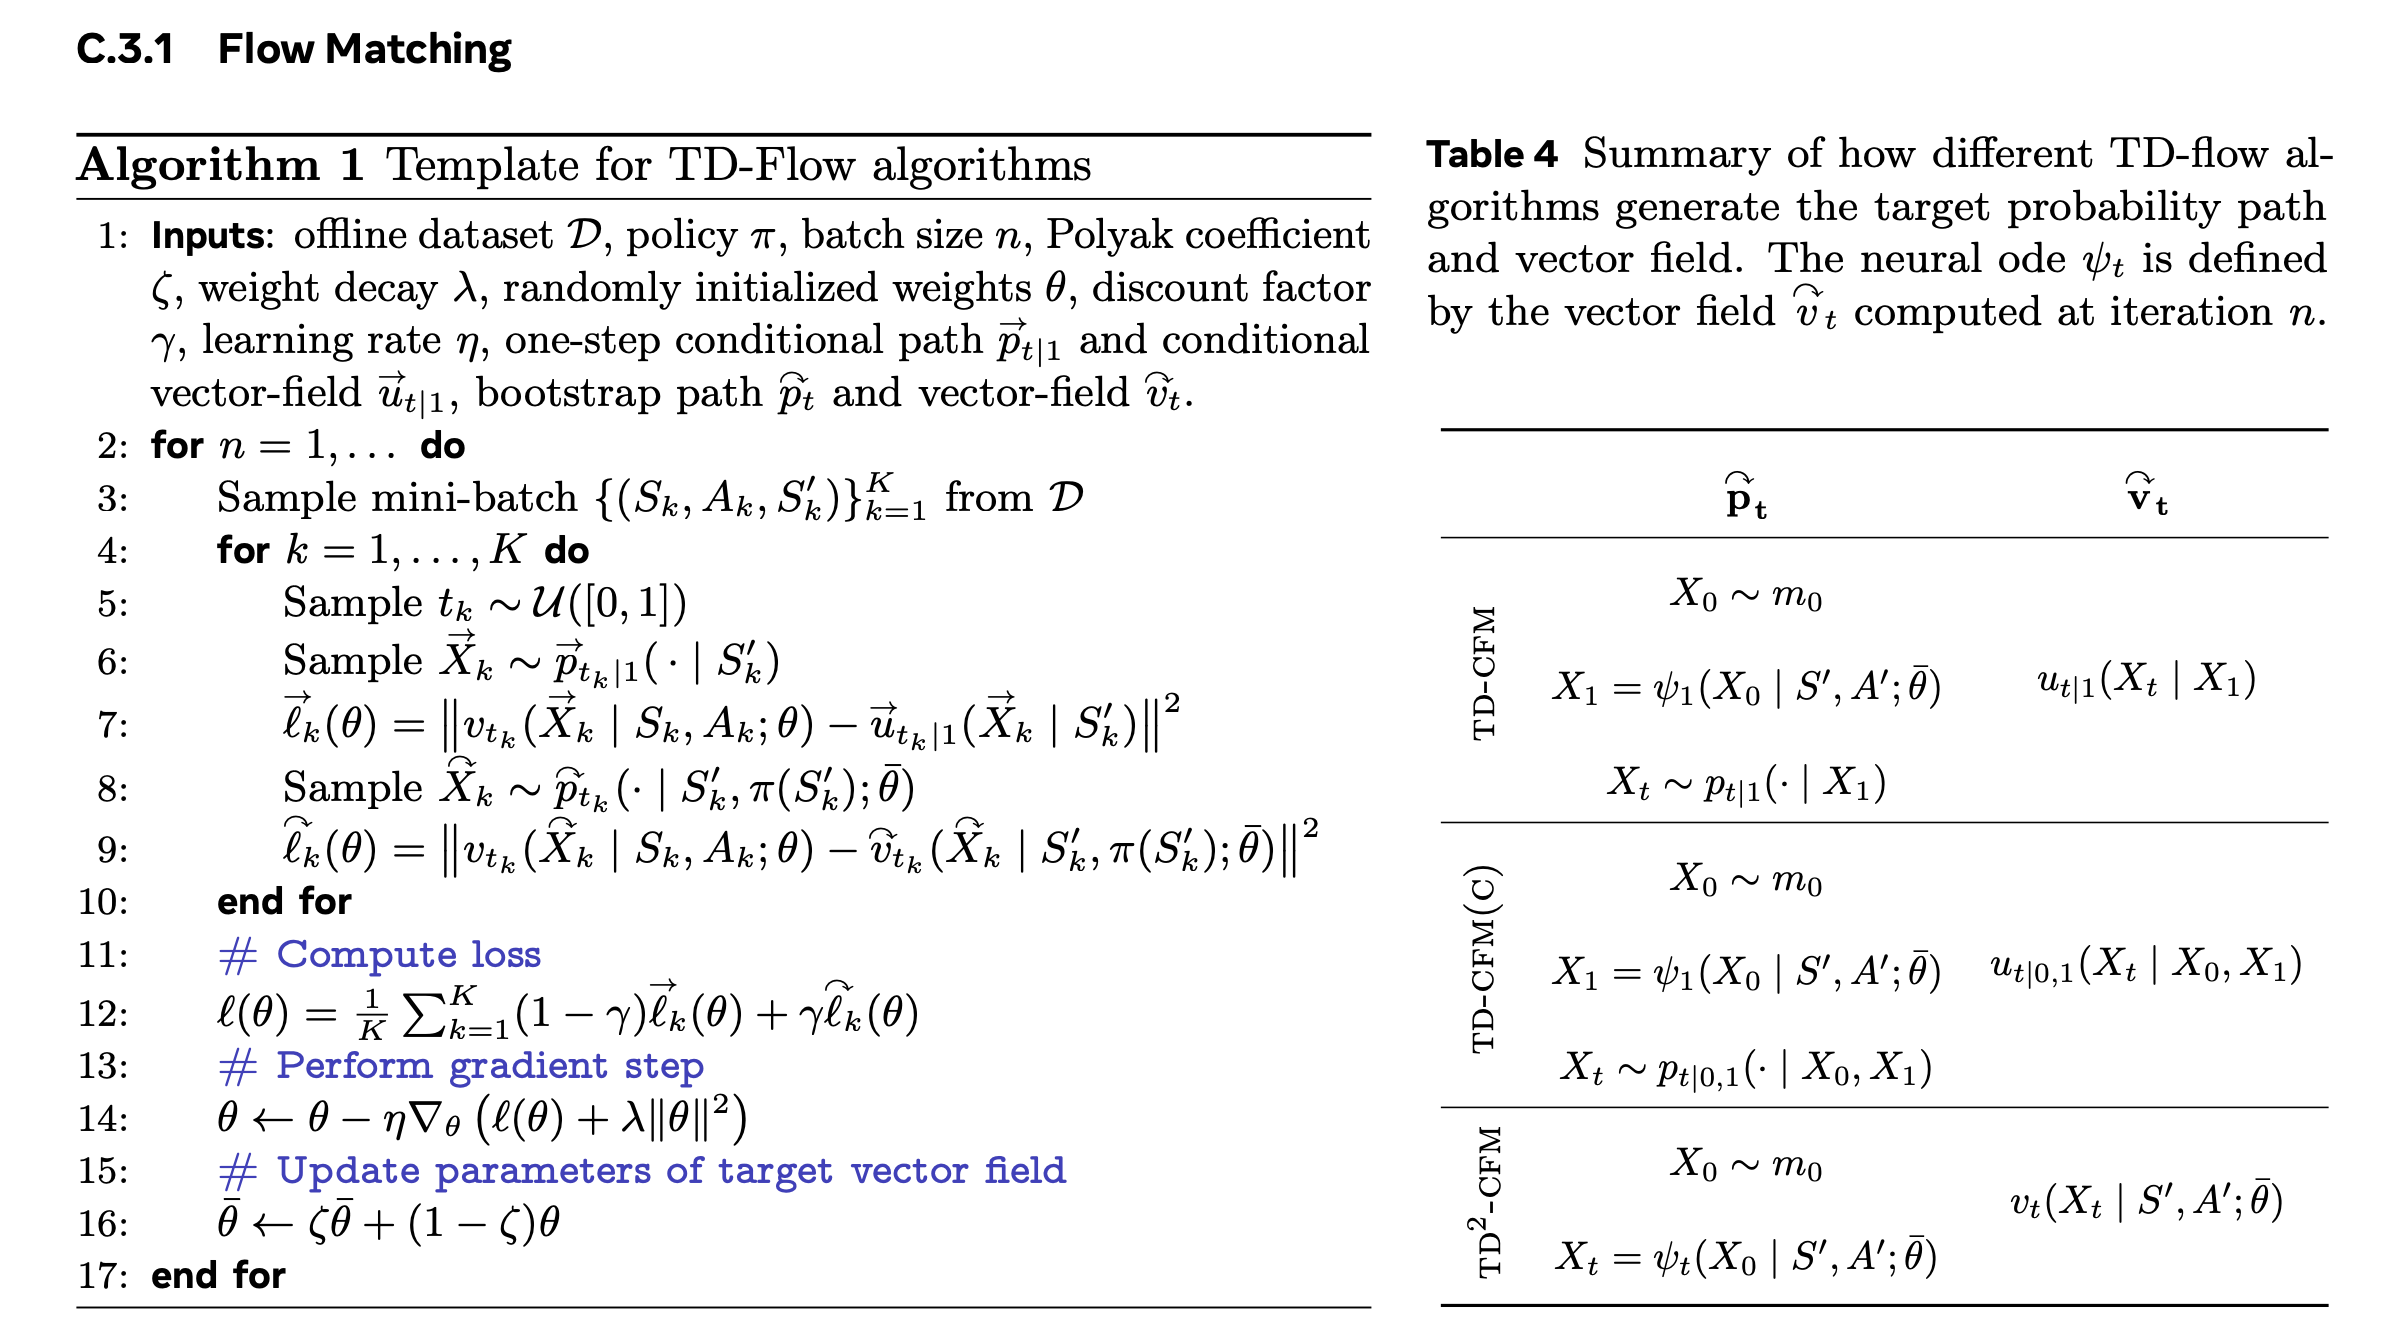

In [5]:
gamma = 0.99
num_epochs = 500
ema = 1e-3
optimizer_config = {
    'lr':1e-4,
    'weight_decay': 1e-3
}

In [6]:
from copy import deepcopy
velocity = TDFlowUnet()
fm = ConditionalFlowMatching(velocity, obs_dim=(4, ))
fm_target = deepcopy(fm)

In [7]:
for k in fm.model.state_dict():
    assert torch.allclose(fm_target.model.state_dict()[k], fm.model.state_dict()[k])

In [8]:
trainer = TDFlowTrainer(
    fm=fm,
    fm_target=fm_target,
    train_loader=train_loader,
    optimizer_config=optimizer_config,
    gamma=gamma,
    ema=ema
)

wandb: Currently logged in as: gerasimov-serf to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [9]:
trainer.fit(num_epochs=num_epochs)

Epoch 0:   3%|▎         | 334/9766 [02:09<1:01:02,  2.57it/s, loss=0.0414, step=334]


KeyboardInterrupt: 

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x10bef1d90>> (for post_run_cell), with arguments args (<ExecutionResult object at 11ed03c50, execution_count=9 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 11ed92f10, raw_cell="trainer.fit(num_epochs=num_epochs)" transformed_cell="trainer.fit(num_epochs=num_epochs)
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/sgerasimov/Desktop/GenAI/TDFlow/demo_tdflow.ipynb#X56sZmlsZQ%3D%3D> result=None>,),kwargs {}:


ConnectionResetError: Connection lost